<a href="https://colab.research.google.com/github/felexkuria/Covid_project/blob/main/covid_19_global_data_tracker_project_PLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data loaded successfully!

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429435 entries, 0 to 429434
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    429435 non-null  object 
 1   continent                                   402910 non-null  object 
 2   location                                    429435 non-null  object 
 3   date                                        429435 non-null  object 
 4   total_cases                                 411804 non-null  float64
 5   new_cases                                   410159 non-null  float64
 6   new_cases_smoothed                          408929 non-null  float64
 7   total_deaths                                411804 non-null  float64
 8   new_deaths                                  410608 non-null  float64
 9   new_deaths_smoothed    

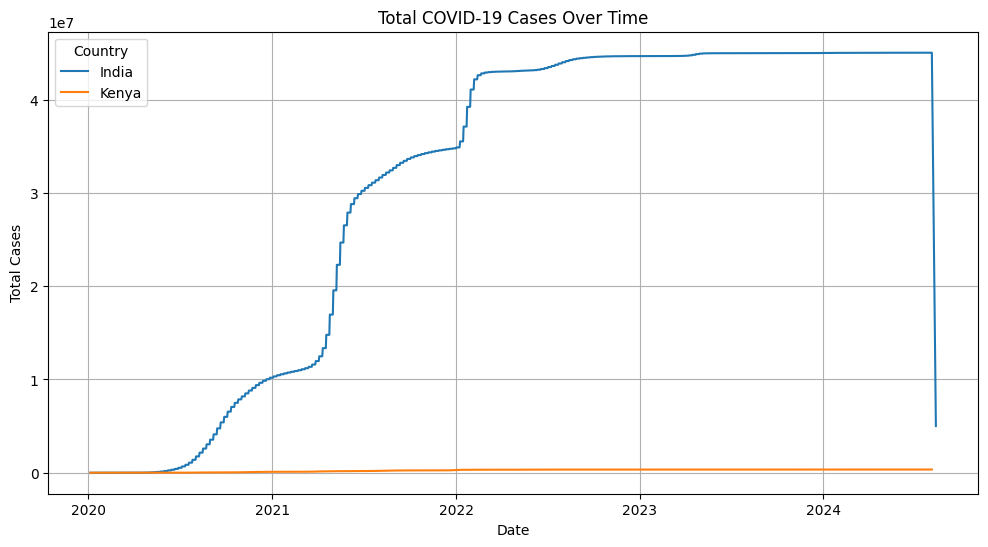

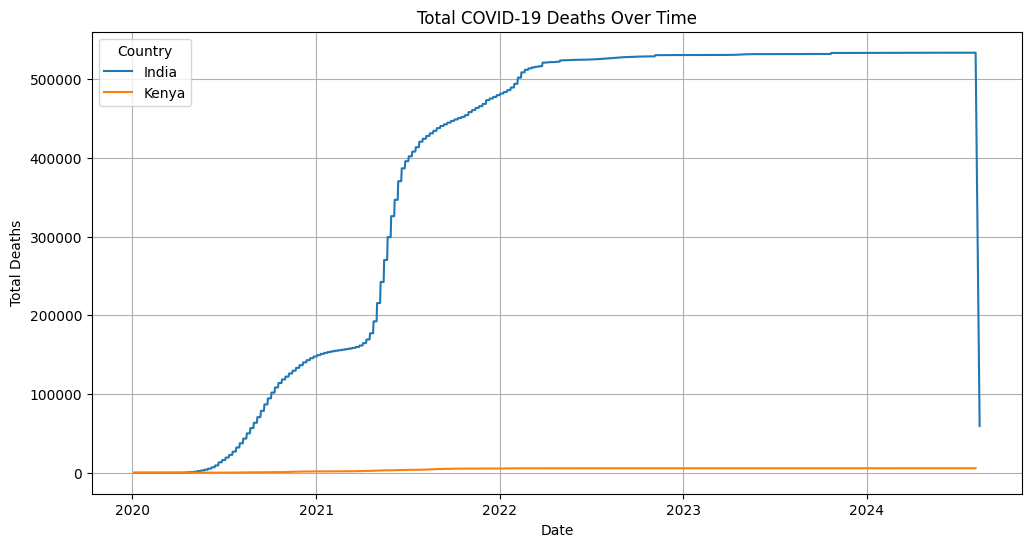

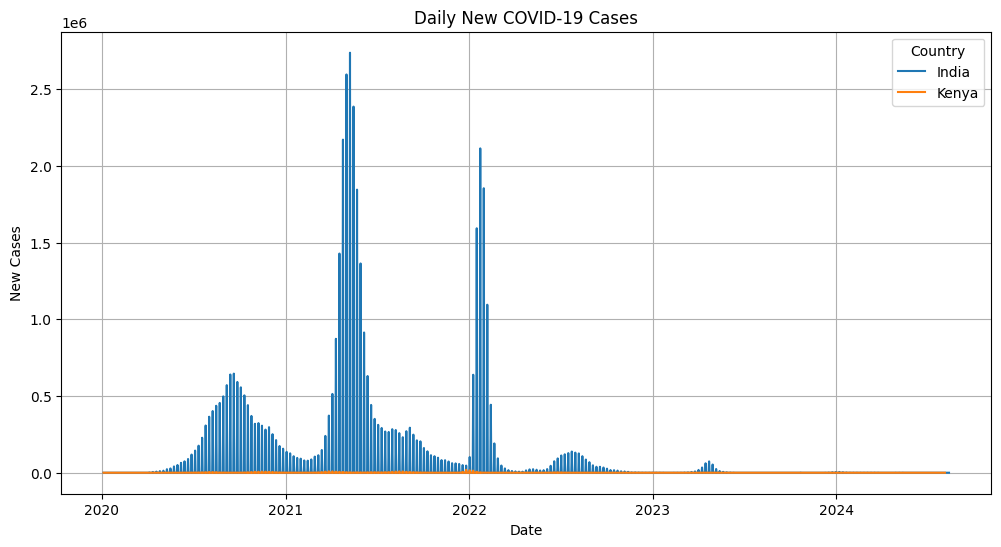

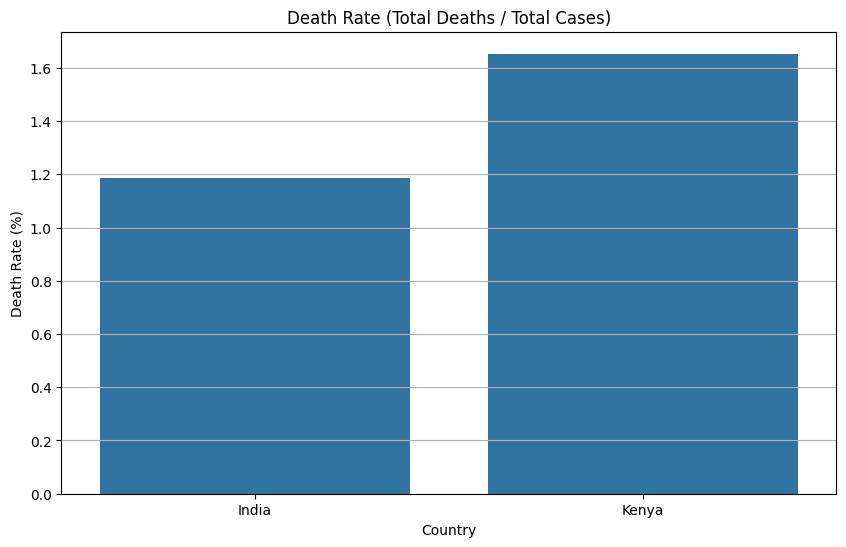

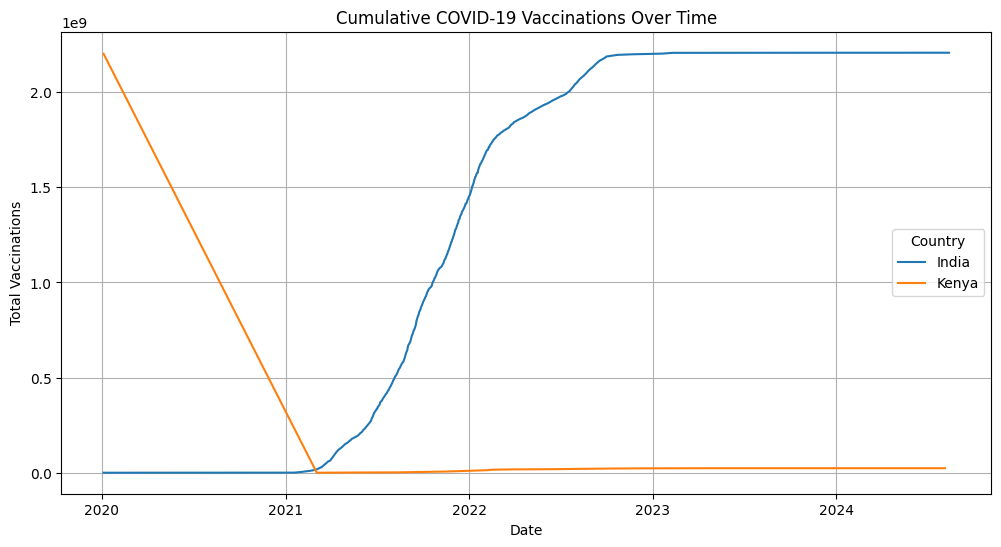

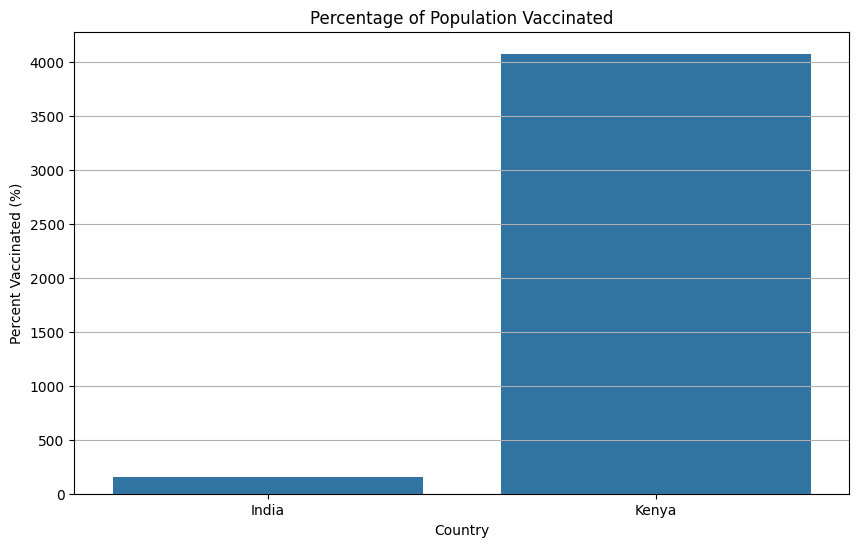


--- Key Insights ---
Insight 1: India has the highest number of total cases: 45,041,748.0
Insight 2: India has the highest number of total deaths: 533,623.0
Insight 3: In India, the average daily increase in total cases was approximately 2977.18.
Insight 3: In Kenya, the average daily increase in total cases was approximately 205.68.

--- End of Insights ---


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# 1️⃣ Data Collection
# The dataset is assumed to be downloaded and saved locally.
# In a real-world scenario, you might use a URL to download the data.
data_url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
df = pd.read_csv(data_url)
# Save to Colab environment
df.to_csv('owid-covid-data.csv', index=False)

# Download to your local machine (this will prompt a download in your browser)
from google.colab import files
files.download('owid-covid-data.csv')
DATA_PATH = 'owid-covid-data.csv'  # Replace with the actual path to your CSV file

# 2️⃣ Data Loading & Exploration
def load_and_explore_data(data_path):
    """
    Loads the COVID-19 dataset, explores its structure, and prints initial information.

    Args:
        data_path (str): The path to the CSV file.

    Returns:
        pandas.DataFrame: The loaded DataFrame, or None if there's an error.
    """
    try:
        df = pd.read_csv(data_path)
        print("Data loaded successfully!")
    except FileNotFoundError:
        print(f"Error: File not found at {data_path}. Please check the file path.")
        return None
    except Exception as e:
        print(f"An error occurred while loading the data: {e}")
        return None

    print("\nColumn Information:")
    print(df.info())  # Use df.info() for a more comprehensive overview

    print("\nFirst 5 rows:")
    print(df.head().to_markdown(index=False, numalign="left", stralign="left")) #Use to_markdown for better output

    print("\nMissing Values:")
    print(df.isnull().sum().to_markdown(numalign="left", stralign="left")) #Use to_markdown for better output
    return df

# 3️⃣ Data Cleaning
def clean_data(df):
    """
    Cleans the COVID-19 dataset by filtering countries, handling missing values,
    and converting the date column to datetime.

    Args:
        df (pandas.DataFrame): The input DataFrame.

    Returns:
        pandas.DataFrame: The cleaned DataFrame, or None if df is None.
    """
    if df is None:
        return None
    # Filter for specific countries
    countries_of_interest = ['Kenya', 'USA', 'India']
    df = df[df['location'].isin(countries_of_interest)].copy() # Make a copy to avoid chained indexing warnings

    # Drop rows with missing dates
    df = df.dropna(subset=['date']).copy()

    # Convert 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'], errors='coerce') # Added errors='coerce'

    # Handle missing numeric values using interpolation
    numeric_cols = ['total_cases', 'total_deaths', 'new_cases', 'new_deaths', 'total_vaccinations']
    for col in numeric_cols:
        # Interpolate missing values, handling potential errors during interpolation
        try:
            df[col] = df[col].interpolate()
        except TypeError:
            print(f"Warning: Interpolation failed for column '{col}'. Filling with 0.")
            df[col] = df[col].fillna(0)  # fill with 0 if interpolation fails.
        except ValueError:
            print(f"Warning: Not enough non-NaN values to interpolate for column '{col}'. Filling with 0.")
            df[col] = df[col].fillna(0)

    #After interpolation, there might still be some NaNs at the beginning
    df[numeric_cols] = df[numeric_cols].fillna(0)
    return df

# 4️⃣ Exploratory Data Analysis (EDA)
def perform_eda(df):
    """
    Performs exploratory data analysis on the COVID-19 dataset, including
    plotting trends and calculating the death rate.

    Args:
        df (pandas.DataFrame): The cleaned DataFrame.
    """
    if df is None:
        return

    # Ensure the 'date' column is actually in datetime format before plotting.
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        try:
            df['date'] = pd.to_datetime(df['date'])
        except ValueError:
            print("Error: 'date' column is not convertible to datetime. Skipping time-based plots.")
            return  # Exit the function if 'date' is not a valid datetime

    # Plot total cases over time for selected countries
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='date', y='total_cases', hue='location', data=df)
    plt.title('Total COVID-19 Cases Over Time')
    plt.xlabel('Date')
    plt.ylabel('Total Cases')
    plt.legend(title='Country')
    plt.grid(True)
    plt.show()

    # Plot total deaths over time
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='date', y='total_deaths', hue='location', data=df)
    plt.title('Total COVID-19 Deaths Over Time')
    plt.xlabel('Date')
    plt.ylabel('Total Deaths')
    plt.legend(title='Country')
    plt.grid(True)
    plt.show()

    # Compare daily new cases between countries
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='date', y='new_cases', hue='location', data=df)
    plt.title('Daily New COVID-19 Cases')
    plt.xlabel('Date')
    plt.ylabel('New Cases')
    plt.legend(title='Country')
    plt.grid(True)
    plt.show()

    # Calculate and plot the death rate
    df_latest = df.groupby('location').agg({'total_deaths': 'max', 'total_cases': 'max'}).reset_index()
    df_latest['death_rate'] = (df_latest['total_deaths'] / df_latest['total_cases']) * 100
    plt.figure(figsize=(10, 6))
    sns.barplot(x='location', y='death_rate', data=df_latest)
    plt.title('Death Rate (Total Deaths / Total Cases)')
    plt.xlabel('Country')
    plt.ylabel('Death Rate (%)')
    plt.grid(axis='y')
    plt.show()

# 5️⃣ Visualizing Vaccination Progress
def visualize_vaccination_progress(df):
    """
    Visualizes COVID-19 vaccination progress over time for selected countries.

    Args:
        df (pandas.DataFrame): The cleaned DataFrame.
    """
    if df is None:
        return

    # Plot cumulative vaccinations over time for selected countries
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='date', y='total_vaccinations', hue='location', data=df)
    plt.title('Cumulative COVID-19 Vaccinations Over Time')
    plt.xlabel('Date')
    plt.ylabel('Total Vaccinations')
    plt.legend(title='Country')
    plt.grid(True)
    plt.show()

    # Calculate and compare % vaccinated population (assuming 'population' is in the dataframe)
    # This part requires population data.  If it's not in your DataFrame, you'll need to merge it in.
    if 'population' in df.columns:
        df_vacc = df.groupby('location').agg({'total_vaccinations': 'max', 'population': 'max'}).reset_index()
        df_vacc['percent_vaccinated'] = (df_vacc['total_vaccinations'] / df_vacc['population']) * 100
        plt.figure(figsize=(10, 6))
        sns.barplot(x='location', y='percent_vaccinated', data=df_vacc)
        plt.title('Percentage of Population Vaccinated')
        plt.xlabel('Country')
        plt.ylabel('Percent Vaccinated (%)')
        plt.grid(axis='y')
        plt.show()
    else:
        print("Warning: Population data is not available. Cannot calculate percentage vaccinated.")

# 6️⃣ Optional: Build a Choropleth Map
def visualize_choropleth_map(df):
    """
    Visualizes COVID-19 cases on a choropleth map using Plotly Express.

    Args:
        df (pandas.DataFrame): The cleaned DataFrame.
    """
    if df is None:
        return

    # Check if plotly is installed
    try:
        import plotly.express as px
    except ImportError:
        print("Plotly is not installed. Skipping choropleth map visualization.")
        print("Please install it using: pip install plotly")
        return

    # Get the latest data for each country
    df_latest = df.groupby('location').last().reset_index() # changed from  df.groupby('location').agg({'total_cases': 'max', 'iso_code': 'last'}).reset_index()
    # Create the choropleth map
    fig = px.choropleth(df_latest,
                        locations="iso_code",  # Changed to iso_code
                        color="total_cases",
                        hover_name="location",
                        color_continuous_scale=px.colors.sequential.Plasma,
                        title="Total COVID-19 Cases by Country (Latest Data)",
                        projection="natural earth")  # You can change the projection
    fig.show()

# 7️⃣ Insights & Reporting
def generate_insights(df):
    """
    Generates and prints key insights from the COVID-19 data.

    Args:
        df (pandas.DataFrame): The cleaned DataFrame.
    """
    if df is None:
        print("No data to generate insights.")
        return

    print("\n--- Key Insights ---")
    # Example insights (these should be tailored to your specific data)
    latest_cases = df.groupby('location')['total_cases'].max()
    max_cases_country = latest_cases.idxmax()
    max_cases = latest_cases.max()
    print(f"Insight 1: {max_cases_country} has the highest number of total cases: {max_cases:,}")

    latest_deaths = df.groupby('location')['total_deaths'].max()
    max_deaths_country = latest_deaths.idxmax()
    max_deaths = latest_deaths.max()
    print(f"Insight 2: {max_deaths_country} has the highest number of total deaths: {max_deaths:,}")

    # Example of calculating a simple trend (you can expand on this)
    for country in df['location'].unique():
        country_df = df[df['location'] == country].copy() # Make a copy
        if len(country_df) > 2:  # Need at least 2 data points to calculate a trend
            cases_start = country_df.iloc[0]['total_cases']
            cases_end = country_df.iloc[-1]['total_cases']
            days = (country_df.iloc[-1]['date'] - country_df.iloc[0]['date']).days
            if days > 0:
                daily_increase = (cases_end - cases_start) / days
                print(f"Insight 3: In {country}, the average daily increase in total cases was approximately {daily_increase:.2f}.")
            else:
                print(f"Insight 3: Insufficient data to calculate daily increase for {country}.")
        else:
             print(f"Insight 3: Insufficient data to calculate daily increase for {country}.")
    print("\n--- End of Insights ---")

def main():
    """
    Main function to orchestrate the data analysis process.
    """
    data_file = DATA_PATH
    df = load_and_explore_data(data_file)
    if df is not None:
        cleaned_df = clean_data(df)
        if cleaned_df is not None:
            perform_eda(cleaned_df)
            visualize_vaccination_progress(cleaned_df)
            visualize_choropleth_map(cleaned_df) # This will only run if plotly is installed
            generate_insights(cleaned_df)

if __name__ == "__main__":
    main()